<a href="https://colab.research.google.com/github/KaviiSuri/Hateful_Memes/blob/master/TFhatefull.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading The Data

In [1]:
! pip install -q kaggle

from google.colab import files

# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download -d parthplc/facebook-hateful-meme-dataset
! ls
! unzip -n ./drive/My\ Drive/datasets/facebook-hateful-meme-dataset.zip -d .
! ls data

data  drive  sample_data
Archive:  ./drive/My Drive/datasets/facebook-hateful-meme-dataset.zip
dev.jsonl  img	LICENSE.txt  README.md	test.jsonl  train.jsonl


In [2]:
! ls data

dev.jsonl  img	LICENSE.txt  README.md	test.jsonl  train.jsonl


In [3]:
import pathlib
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

np.set_printoptions(precision=4)

In [4]:
train_df = pd.read_json('./data/train.jsonl', lines=True)

In [5]:
val_df = pd.read_json('./data/dev.jsonl', lines=True)

In [6]:
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


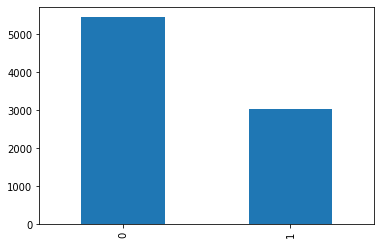

In [7]:
train_df['label'].value_counts().plot(kind='bar')

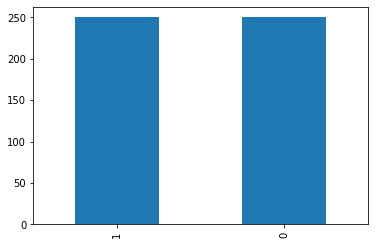

In [8]:
val_df['label'].value_counts().plot(kind='bar')

In [9]:
val_df.head()

,id,img,label,text
0,8291,img/08291.png,1,white people is this a shooting range
1,46971,img/46971.png,1,bravery at its finest
2,3745,img/03745.png,1,your order comes to $37.50 and your white priv...
3,83745,img/83745.png,1,it is time.. to send these parasites back to t...
4,80243,img/80243.png,1,mississippi wind chime


In [10]:
train_df.head()

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [12]:
meme_text_tokenizer = Tokenizer()
meme_text_tokenizer.fit_on_texts(train_df['text'])
VOCAB_SIZE = len(meme_text_tokenizer.word_index) + 1

In [13]:
def df_to_dataset(df, path, pad_len=None,shuffle=False):
  """
  Function to turn a pandas dataframe into a tf.dataset and also 
  changes the column name of the original dataframe along with adding the 
  path to the data folder to the img paths

  Arguments
  ---------
  df (pandas.dataframe):
    the dataframe to be processed
  
  path (string):
    relative path to the data directory from current, SLASH INCLUDED

  shuffle (bool):
    shuffling is done when this is true
  
  Returns
  -------
  ds (tf.dataset):
    the converted dataset
  """

  # Change  the Column Names
  df.columns = ["id", "img_name", "label", "text"]
  # Correct the path
  df['img_name'] = path + df['img_name']
  # Copy the dataframe and seprate the label
  df = df.copy()
  label = df.pop("label")
  # Convert to a dataset
  encoded_text = meme_text_tokenizer.texts_to_sequences(df['text'])
  if pad_len:
    padded_text = pad_sequences(encoded_text, maxlen=pad_len)
  else:
    padded_text = pad_sequences(encoded_text)
  df_dict = (dict(df)) 
  df_dict['text'] = padded_text
  ds = tf.data.Dataset.from_tensor_slices((df_dict, label))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(df))
  return ds


In [14]:
train_ds = df_to_dataset(train_df, './data/',shuffle=True)

In [15]:
train_df.head()

,id,img_name,label,text
0,42953,./data/img/42953.png,0,its their character not their color that matters
1,23058,./data/img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,./data/img/13894.png,0,putting bows on your pet
3,37408,./data/img/37408.png,0,i love everything and everybody! except for sq...
4,82403,./data/img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


In [16]:
train_ds.element_spec

({'id': TensorSpec(shape=(), dtype=tf.int64, name=None),
  'img_name': TensorSpec(shape=(), dtype=tf.string, name=None),
  'text': TensorSpec(shape=(70,), dtype=tf.int32, name=None)},
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [17]:
val_ds = df_to_dataset(val_df, './data/', pad_len=70, shuffle=True)

# Preprocessing the Data

In [18]:
def preprocess_img(elem, label):
  filename = elem['img_name']
  image = tf.io.read_file(filename)
  image = tf.image.decode_png(image, channels = 3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [224, 224])
  elem["img"] = image #[40:24+170]

  return elem, label

In [19]:
preprocess_img({'img_name':'./data/img/42953.png' }, 0)[0]['img'][:, : , 0].shape

TensorShape([224, 224])

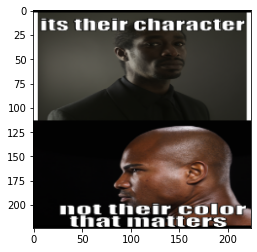

In [20]:
plt.imshow(preprocess_img({'img_name':'./data/img/42953.png' }, 0)[0]['img'])

In [21]:
def img_plotter(ds):
  rows=5
  cols=5
  fig, axes = plt.subplots(rows,cols,figsize=(30,12))
  plt.subplots_adjust(wspace=0.1,hspace=0.2)
  # features=['INDUS','RM', 'AGE', 'DIS','PTRATIO','MEDV']
  plotnum=1
  for idx in range(rows * cols):
      plt.subplot(rows,cols,plotnum)
      plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
      plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
      
      for elem, label in ds.take(1):
        plt.imshow(elem['img'])
        plt.title(f"{elem['img_name']} - {label}")
      plotnum=plotnum+1
  plt.show()

In [22]:
train_ds = train_ds.map(preprocess_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [23]:
val_ds = val_ds.map(preprocess_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

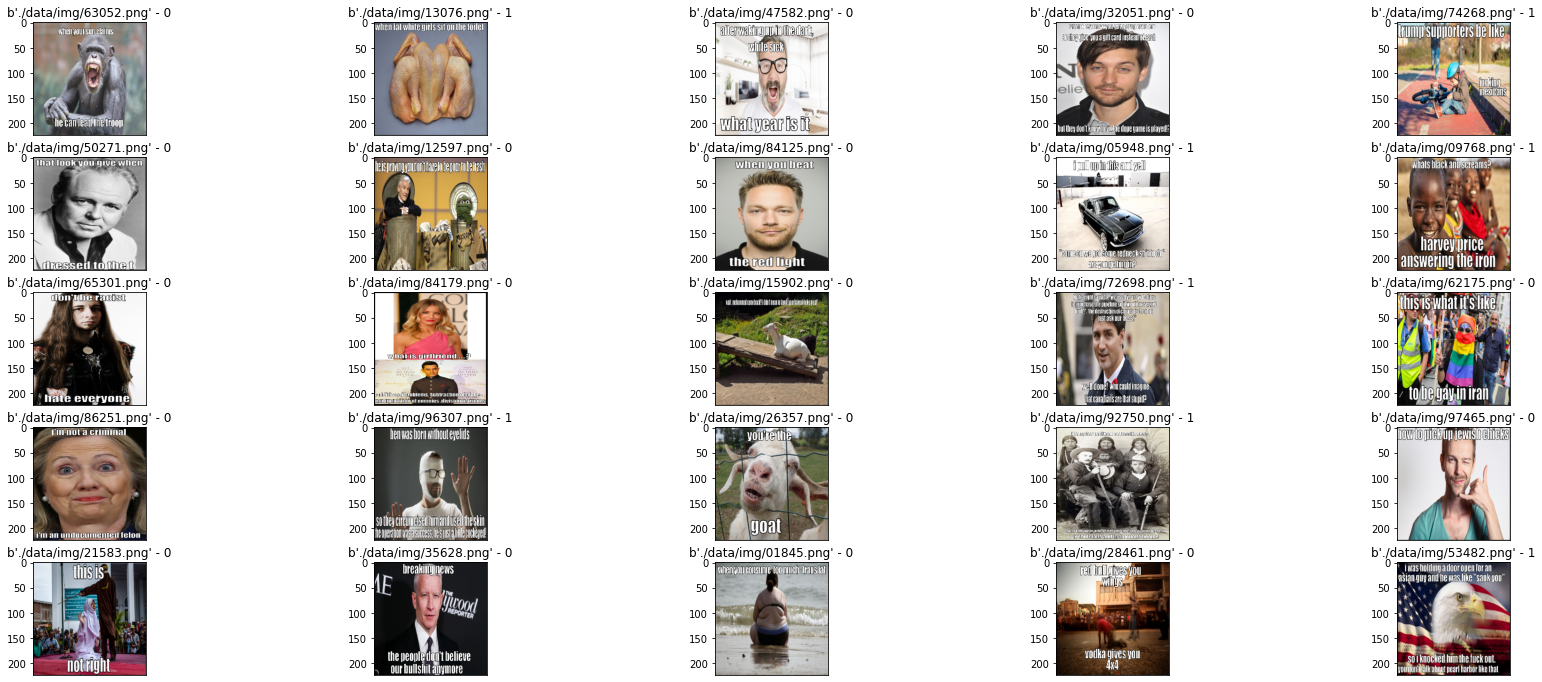

In [24]:
img_plotter(train_ds)

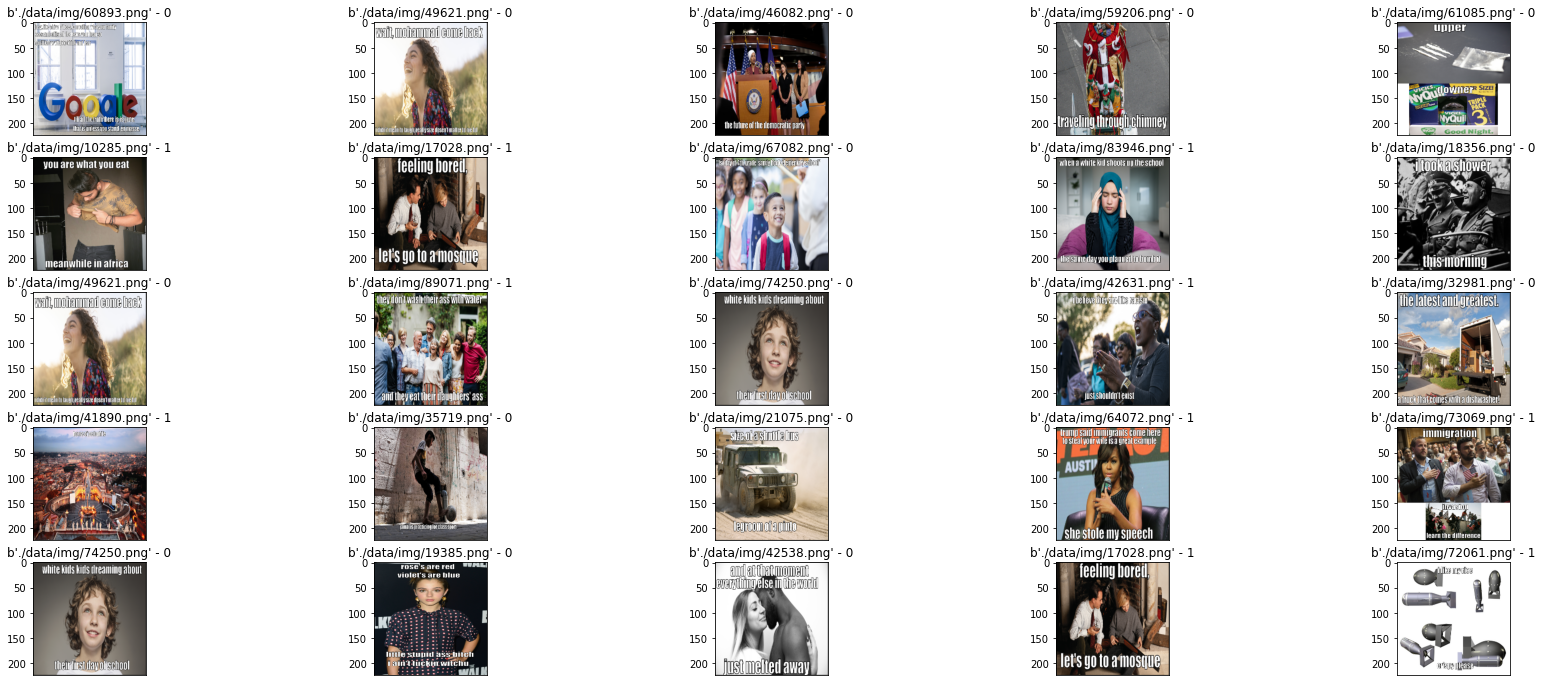

In [25]:
img_plotter(val_ds)

# Setting Up GloVe Embeddings

In [25]:
print('Indexing word vectors.')

embeddings_index = {}
f = open('./drive/My Drive/Embeddings/GloVe/glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Loaded %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Loaded 400000 word vectors.


In [26]:
embedding_matrix = np.zeros((VOCAB_SIZE, 100))
for word, i in meme_text_tokenizer.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [27]:
embedding_matrix

array([[ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [-0.0382, -0.2449,  0.7281, ..., -0.1459,  0.8278,  0.2706],
       [-0.4989,  0.766 ,  0.8975, ..., -0.4118,  0.4054,  0.785 ],
       ...,
       [ 0.0325,  0.1449,  0.3058, ..., -0.1213,  0.0936,  0.6032],
       [ 0.0529,  0.1576,  0.6492, ..., -0.4028, -0.4377,  0.4379],
       [-0.0946,  0.1301, -0.0605, ...,  0.3486, -0.2128,  0.1638]])

In [28]:
train_ds.element_spec

({'id': TensorSpec(shape=(), dtype=tf.int64, name=None),
  'img': TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None),
  'img_name': TensorSpec(shape=(), dtype=tf.string, name=None),
  'text': TensorSpec(shape=(70,), dtype=tf.int32, name=None)},
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [29]:
def plot_metrics(history):
  fig = plt.figure(figsize=(18, 12))

  plt.subplot(2, 3, 1)
  plt.plot(history.history['loss'], label='training')
  plt.plot(history.history['val_loss'], label='validation')
  plt.legend()
  plt.title('Loss')


  plt.subplot(2, 3, 2)
  plt.plot(history.history['accuracy'], label='training')
  plt.plot(history.history['val_accuracy'], label='validation')
  plt.legend()
  plt.title('Accuracy')


  plt.subplot(2, 3, 3)
  plt.plot(history.history['f1_score'], label='training')
  plt.plot(history.history['val_f1_score'], label='validation')
  plt.legend()
  plt.title('F1')

  plt.subplot(2, 3, 4)
  plt.plot(history.history['precision'], label='training')
  plt.plot(history.history['val_precision'], label='validation')
  plt.legend()
  plt.title('Precison')

  plt.subplot(2, 3, 5)
  plt.plot(history.history['recall'], label='training')
  plt.plot(history.history['val_recall'], label='validation')
  plt.legend()
  plt.title('Recall')

  plt.show()

In [30]:
def plot_prediction_range(model, ds):
  plt.plot([0.7]*32)
  plt.plot([0.5]*32)
  plt.plot([0.3]*32)
  # plt.plot([1]*32)
  # plt.plot([0]*32)


  for elem, label in ds.prefetch(tf.data.experimental.AUTOTUNE).cache().shuffle(buffer_size=500).batch(32).take(1):
    plt.plot(model.predict(elem))
    print(model.evaluate(elem, label))
    print(label.numpy())
    # plt.plot()

# Establishing a Baseline model by just using the efficient net

In [31]:
! pip install -U --pre efficientnet

Requirement already up-to-date: efficientnet in /usr/local/lib/python3.6/dist-packages (1.1.0)


In [32]:
from tensorflow.keras.layers import BatchNormalization, Dropout, Activation, Dense, Flatten, Conv2D, MaxPool2D, AveragePooling2D, Input
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential

In [33]:
import efficientnet.tfkeras as efn
class EffNetFeatureExtractor(tf.keras.Model):
  """
  Conv Part of the Model, This just takes in images and runs them in efficientNet and then applies batchNorm and dropout
  This uses EfficeintNetB0 ri8 now
  """
  def __init__(self, input_shape=(224, 224, 3), dropout_rate=0.7,  weights='imagenet', pooling='avg', name=None, include_top=False):
    """
    This  function initializes the Model and saves the prop, layers will be Initialized
    in the build function
    Arguments
    ---------
    dropout_rate (int):
      BETWEEN 0 and 1
      This model has a single dropout layers, this is the rate of the layer

    weights
    """
    super(EffNetFeatureExtractor, self).__init__(name=name)
    self.effNet = efn.EfficientNetB0(weights=weights, 
                                           pooling=pooling, 
                                           input_shape=input_shape, 
                                           include_top=False
                                           )
    self.effNet.trainable = False
    self.batchNorm = BatchNormalization()
    self.dropout = Dropout(dropout_rate)
    self.flatten = Flatten()
    self.fc1 = Dense(1024, activation='relu')
    self.dense = Dense(1 ,activation='sigmoid', name='effnet_prediction')
  
  def call(self, inputs):
    x = self.effNet(inputs)
    x = self.batchNorm(x)
    x = self.dropout(x)
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.dense(x)
    return x

In [60]:
eff_model = EffNetFeatureExtractor()

16809984/16804768 [==============================] - 1s 0us/step


In [61]:
eff_model.compile(optimizer=SGD(), loss='binary_crossentropy', metrics=['accuracy', f1, precision, recall])


In [62]:
history = eff_model.fit(
      train_ds.prefetch(tf.data.experimental.AUTOTUNE).cache().shuffle(buffer_size=6000).batch(64),
      validation_data=val_ds.prefetch(tf.data.experimental.AUTOTUNE).cache().shuffle(buffer_size=500).batch(64),
      epochs=20,
      # class_weight={0: 1, 1: train_df['label'].value_counts()[0]/train_df['label'].value_counts()[1]}
    )

Epoch 1/20
133/133 [==============================] - 46s 347ms/step - loss: 0.7974 - accuracy: 0.5822 - f1_score: 0.3434 - precision: 0.3941 - recall: 0.3042 - val_loss: 0.6977 - val_accuracy: 0.5140 - val_f1_score: 0.5606 - val_precision: 0.5116 - val_recall: 0.6200
Epoch 2/20
133/133 [==============================] - 17s 127ms/step - loss: 0.7385 - accuracy: 0.5892 - f1_score: 0.3282 - precision: 0.3971 - recall: 0.2797 - val_loss: 0.6993 - val_accuracy: 0.5320 - val_f1_score: 0.4236 - val_precision: 0.5513 - val_recall: 0.3440
Epoch 3/20
133/133 [==============================] - 17s 126ms/step - loss: 0.6965 - accuracy: 0.6111 - f1_score: 0.3513 - precision: 0.4374 - recall: 0.2934 - val_loss: 0.7030 - val_accuracy: 0.5320 - val_f1_score: 0.4179 - val_precision: 0.5526 - val_recall: 0.3360
Epoch 4/20
133/133 [==============================] - 17s 126ms/step - loss: 0.6894 - accuracy: 0.6141 - f1_score: 0.3400 - precision: 0.4401 - recall: 0.2770 - val_loss: 0.7366 - val_accuracy:

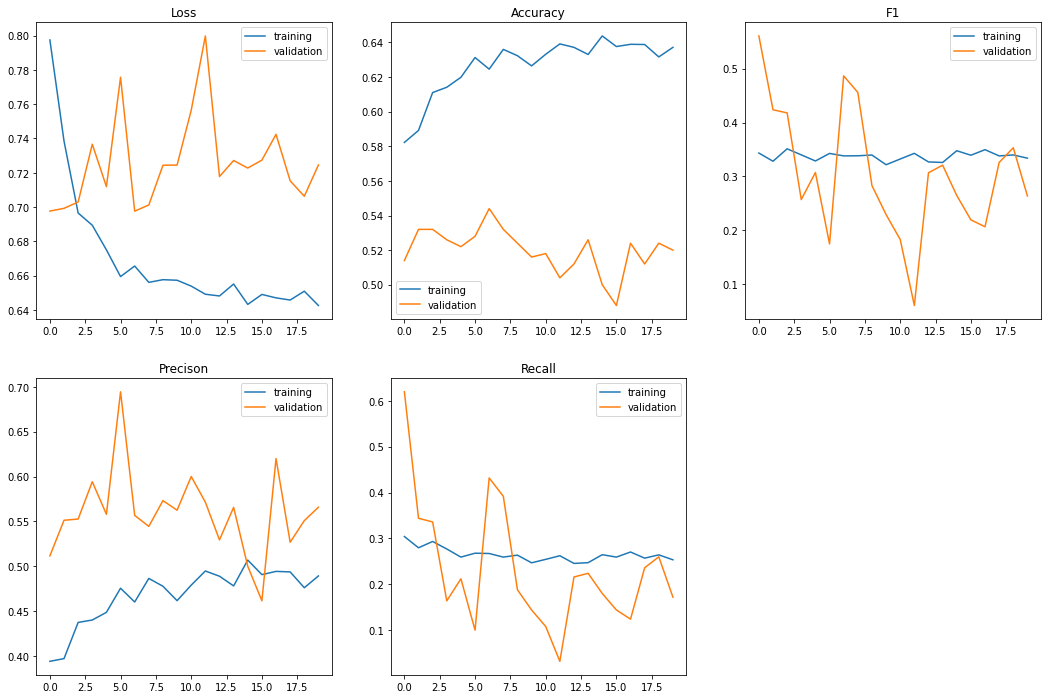

In [63]:
plot_metrics(history)

1/1 [==============================] - 0s 2ms/step - loss: 0.6900 - accuracy: 0.5938 - f1_score: 0.1333 - precision: 0.3333 - recall: 0.0833
[0.6899621486663818, 0.59375, array([0.1333], dtype=float32), 0.3333333432674408, 0.0833333358168602]
[0 1 0 1 1 0 0 1 0 0 0 0 0 1 1 0 1 1 0 0 0 1 0 0 0 1 0 0 1 0 1 0]


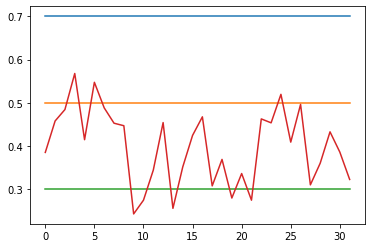

In [64]:
plot_prediction_range(eff_model, val_ds)

In [34]:

class ConvNetFeatureExtractor(tf.keras.Model):
  """
  Conv Part of the Model, This just takes in images and runs them in efficientNet and then applies batchNorm and dropout
  This uses EfficeintNetB0 ri8 now
  """
  def __init__(self, input_shape=(224, 224, 3), dropout_rate=0.3,  weights='imagenet', pooling='avg', name=None, include_top=False):
    """
    This  function initializes the Model and saves the prop, layers will be Initialized
    in the build function
    Arguments
    ---------
    dropout_rate (int):
      BETWEEN 0 and 1
      This model has a single dropout layers, this is the rate of the layer

    weights
    """
    super(ConvNetFeatureExtractor, self).__init__(name=name)
    self.conv_block1 = Sequential([
        Conv2D(64, (3, 3)),
        Conv2D(64, (3, 3)),
        BatchNormalization(),
        Dropout(dropout_rate),
        MaxPool2D(pool_size=(3, 3)),
    ])
    

    self.conv_block2 = Sequential([
        Conv2D(64, (3, 3)),
        Conv2D(64, (3, 3)),
        BatchNormalization(),
        Dropout(dropout_rate),
        MaxPool2D(pool_size=(3, 3)),
    ])

    self.conv_block3 = Sequential([
        Conv2D(32, (3, 3)),
        Conv2D(32, (3, 3)),
        BatchNormalization(),
        Dropout(dropout_rate),
        MaxPool2D(pool_size=(3, 3)),
    ])
    
    self.flatten = Flatten()
    self.fc1 = Dense(1024, activation='relu', activity_regularizer=tf.keras.regularizers.l2())
    # if include_top:
    self.dense_final = Dense(1, activation='sigmoid')
  
  def call(self, inputs):
    x = self.conv_block1(inputs['img'])
    x = self.conv_block2(x)
    x = self.conv_block3(x)
    x = self.flatten(x)
    x = self.fc1(x)
    # if include_top:
    x = self.dense_final(x)
    return x

In [38]:
conv_model = ConvNetFeatureExtractor()

In [47]:
tf.random.set_seed(42)

In [48]:
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.metrics import Precision, Recall
f1 = F1Score(num_classes=1, threshold=0.5)
precision  = Precision(name='precision')
recall = Recall(name='recall')

In [49]:
conv_model.compile(optimizer=SGD(), loss='binary_crossentropy', metrics=['accuracy', f1, precision, recall])

In [50]:
history = conv_model.fit(
      train_ds.prefetch(tf.data.experimental.AUTOTUNE).cache().shuffle(buffer_size=6000).batch(64),
      validation_data=val_ds.prefetch(tf.data.experimental.AUTOTUNE).cache().shuffle(buffer_size=500).batch(64),
      epochs=20,
      # class_weight={0: 1, 1: train_df['label'].value_counts()[0]/train_df['label'].value_counts()[1]}
    )

Epoch 1/20
133/133 [==============================] - 72s 539ms/step - loss: 0.6334 - accuracy: 0.6500 - f1_score: 0.0775 - precision: 0.7143 - recall: 0.0410 - val_loss: 0.7394 - val_accuracy: 0.5000 - val_f1_score: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
133/133 [==============================] - 53s 401ms/step - loss: 0.6308 - accuracy: 0.6489 - f1_score: 0.0762 - precision: 0.6833 - recall: 0.0403 - val_loss: 0.7315 - val_accuracy: 0.5000 - val_f1_score: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
133/133 [==============================] - 53s 398ms/step - loss: 0.6300 - accuracy: 0.6513 - f1_score: 0.0857 - precision: 0.7240 - recall: 0.0456 - val_loss: 0.7153 - val_accuracy: 0.4940 - val_f1_score: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
133/133 [==============================] - 53s 399ms/step - loss: 0.6274 - accuracy: 0.6506 - f1_score: 0.0873 - precision: 0.6961 - recall: 0.046

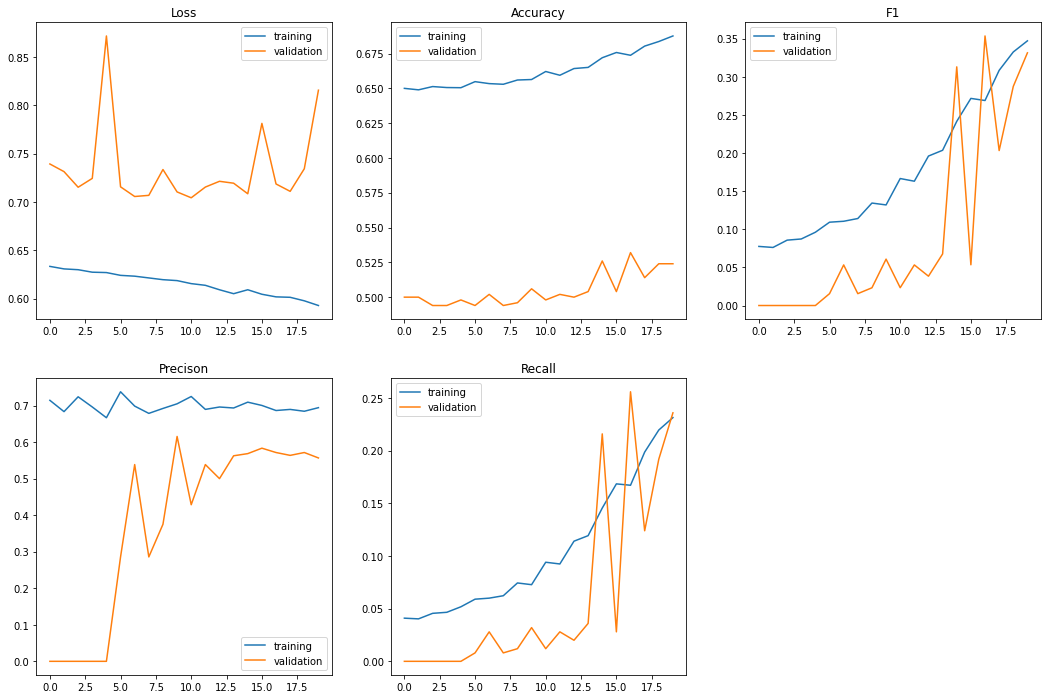

In [53]:
plot_metrics(history)

1/1 [==============================] - 0s 2ms/step - loss: 0.9864 - accuracy: 0.3438 - f1_score: 0.2222 - precision: 0.4286 - recall: 0.1500
[0.9863873720169067, 0.34375, array([0.2222], dtype=float32), 0.4285714328289032, 0.15000000596046448]
[1 1 0 1 1 1 1 0 0 1 1 1 0 1 1 0 1 1 0 1 1 0 0 1 0 1 0 0 1 1 1 0]


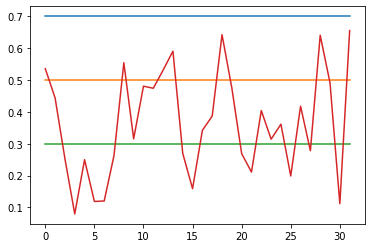

In [54]:
plot_prediction_range(conv_model, val_ds)

In [35]:
from tensorflow.keras.layers import Embedding, LSTM, Concatenate, GlobalMaxPool1D

In [36]:
from tensorflow.keras.regularizers import l2

In [37]:
class TextFeatureExtractor(tf.keras.Model):
  """
  This is the part of the model that takes x as input and uses Embeddings and LSTMs to give an output
  """
  def __init__(self, vocab_size, embedding_weights, dimensions=100, input_length=70, name=None):
    super(TextFeatureExtractor, self).__init__(name=name)
    self.embedding_layer = Embedding(vocab_size, 
                                     dimensions, 
                                     input_length=input_length, 
                                     weights=embedding_weights,
                                     trainable=False
                                     )
    self.lstm_1 = LSTM(16,)
  def call(self, inputs):
    x = self.embedding_layer(inputs)
    x = self.lstm_1(x)
    return x


In [38]:
class BaseLineModel(tf.keras.Model):
  """
  This combines both feature extractors and adds some more layers to make the prediction
  """
  def __init__(self,
               txt_vocab_size,
               txt_embedding_weights,
               txt_embedding_dimensions=100,
               txt_input_length=70,
               img_input_shape=(224, 224, 3), 
               img_dropout_rate=0.3,  
               img_effnet_weights='imagenet', 
               img_effnet_pooling='avg'):
    super(BaseLineModel, self).__init__()
    # Save all the inputs
    self.txt_vocab_size = txt_vocab_size
    self.txt_embedding_weights = txt_embedding_weights
    self.txt_embedding_dimensions = txt_embedding_dimensions
    self.txt_input_length = txt_input_length
    self.img_input_shape = img_input_shape
    self.img_dropout_rate = img_dropout_rate
    self.img_effnet_weights = img_effnet_weights
    self.img_effnet_pooling = img_effnet_pooling

    # Create the 2 blocks
    ## Left
    self.txt_feature_extractor = TextFeatureExtractor(self.txt_vocab_size, 
                                                      self.txt_embedding_weights,
                                                      self.txt_embedding_dimensions,
                                                      self.txt_input_length,
                                                      name='left-text-extractor'
                                                      )
    # Right
    self.img_feature_extractor = EffNetFeatureExtractor(self.img_input_shape,
                                                        self.img_dropout_rate,
                                                        self.img_effnet_weights,
                                                        self.img_effnet_pooling,
                                                        name='right-img-extractor'
                                                        )
    # self.img_feature_extractor = ConvNetFeatureExtractor(dropout_rate=img_dropout_rate, name='right-img-extractor')
    self.concat = Concatenate()
    # Create Rest of the Model
    self.batchNorm_1 = BatchNormalization()
    self.dropout = Dropout(img_dropout_rate)
    # self.dense_1 = Dense(1024, activation='relu')
    # self.dense_2 = Dense(512, activation='relu')
    self.dense_3 = Dense(128, activation='relu', activity_regularizer=tf.keras.regularizers.l2())
    self.dense_4 = Dense(1, activation='sigmoid', activity_regularizer=tf.keras.regularizers.l2())
  
  def call(self, inputs):
    input_txt = inputs['text']
    input_img = inputs['img']

    # Execute the Left Block
    left_x = self.txt_feature_extractor(input_txt)
    # Execute the Right Block
    right_x = self.img_feature_extractor(input_img)
    # Concatenate
    x = self.concat([left_x, right_x])
    # x = self.batchNorm_1(x)
    # x = self.dense_1(x)
    # x = self.dropout(x)
    # x = self.dense_2(x)
    # x = self.dropout(x)
    x = self.dense_3(x)
    x = self.dropout(x)
    x = self.dense_4(x)
    return x

In [39]:
tf.random.set_seed(42)

In [40]:
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.metrics import Precision, Recall
f1 = F1Score(num_classes=1, threshold=0.5)
precision  = Precision(name='precision')
recall = Recall(name='recall')

In [45]:
completeModel1 = BaseLineModel(VOCAB_SIZE, [embedding_matrix])
completeModel1.compile(optimizer=SGD(), loss='binary_crossentropy', metrics=['accuracy', f1, precision, recall])

In [46]:
history = completeModel1.fit(
      train_ds.prefetch(tf.data.experimental.AUTOTUNE).cache().shuffle(buffer_size=6000).batch(64),
      validation_data=val_ds.prefetch(tf.data.experimental.AUTOTUNE).cache().shuffle(buffer_size=500).batch(64),
      epochs=20,
      class_weight={0: 1, 1: train_df['label'].value_counts()[0]/train_df['label'].value_counts()[1]}
    )

Epoch 1/20
133/133 [==============================] - 47s 352ms/step - loss: 0.9047 - accuracy: 0.4744 - f1_score: 0.4354 - precision: 0.3546 - recall: 0.5639 - val_loss: 0.7040 - val_accuracy: 0.5220 - val_f1_score: 0.5599 - val_precision: 0.5188 - val_recall: 0.6080
Epoch 2/20
133/133 [==============================] - 17s 131ms/step - loss: 0.9019 - accuracy: 0.5045 - f1_score: 0.4203 - precision: 0.3622 - recall: 0.5007 - val_loss: 0.7020 - val_accuracy: 0.5320 - val_f1_score: 0.5585 - val_precision: 0.5286 - val_recall: 0.5920
Epoch 3/20
133/133 [==============================] - 17s 130ms/step - loss: 0.8987 - accuracy: 0.4987 - f1_score: 0.4335 - precision: 0.3646 - recall: 0.5344 - val_loss: 0.7006 - val_accuracy: 0.5260 - val_f1_score: 0.5031 - val_precision: 0.5286 - val_recall: 0.4800
Epoch 4/20
133/133 [==============================] - 17s 130ms/step - loss: 0.8963 - accuracy: 0.5088 - f1_score: 0.4283 - precision: 0.3677 - recall: 0.5128 - val_loss: 0.6996 - val_accuracy:

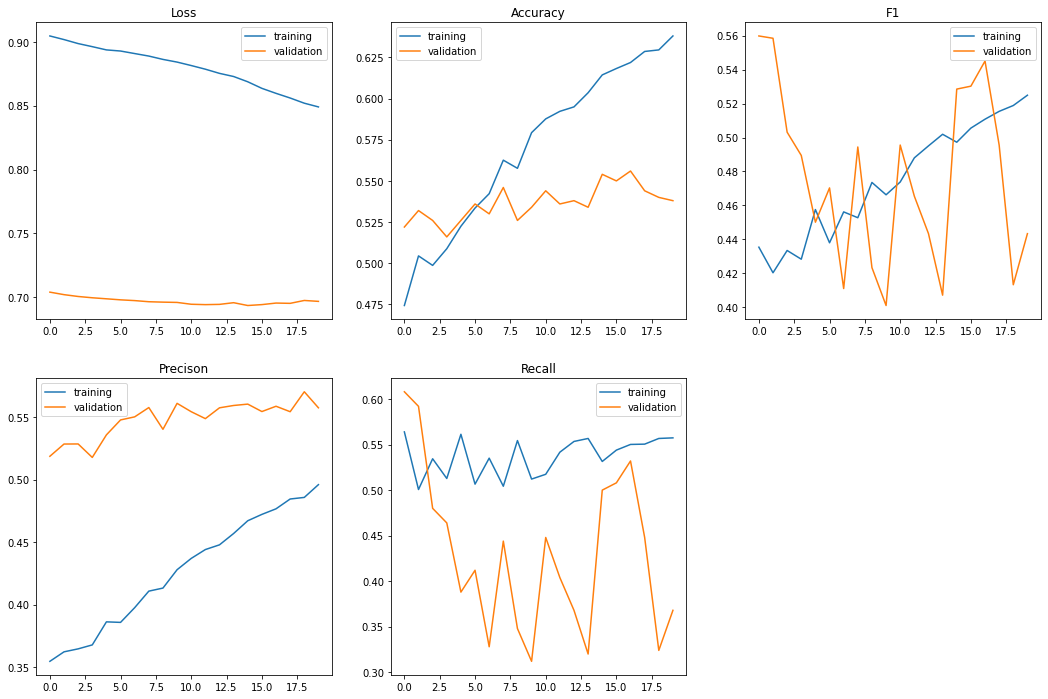

In [47]:
plot_metrics(history)

1/1 [==============================] - 0s 3ms/step - loss: 0.7108 - accuracy: 0.4375 - f1_score: 0.3571 - precision: 0.5000 - recall: 0.2778
[0.7107710242271423, 0.4375, array([0.3571], dtype=float32), 0.5, 0.2777777910232544]
[1 1 1 1 0 1 1 0 0 0 0 1 1 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 1 1 0]


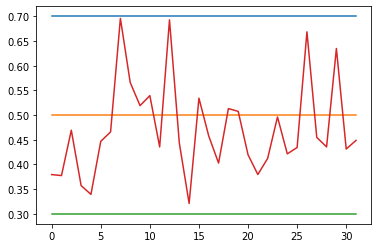

In [48]:
plot_prediction_range(completeModel1, val_ds)

In [ ]:
train_df['label'].value_counts()[0]/train_df['label'].value_counts()[1]

In [ ]:
val_df['label'].value_counts()

In [ ]:
for elem, label in train_ds.prefetch(tf.data.experimental.AUTOTUNE).cache().shuffle(buffer_size=500).batch(32).take(4):
  print(label)

In [ ]:
plt.plot(completeModel1.dense_4.weights[0].numpy())

completeModel1.dense_4.weights[0].numpy()


In [ ]:

# for weight in completeModel1.dense_3.weights:
#   plt.plot(weight.numpy())
print(len(completeModel1.dense_3.weights))
print(completeModel1.dense_3.weights[0].shape)
print(completeModel1.dense_3.weights[1].shape)

In [ ]:
plt.plot(completeModel1.dense_3.weights[0].numpy())


In [ ]:
plt.plot(completeModel1.dense_3.weights[1].numpy())
